# ５章　ラベルなしデータでの事前学習

## 5.1 テキスト生成モデルの評価

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torch.nn as nn
from chapters_code.ch05_previous_chapters import GPTModel

In [50]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 語彙サイズ
    "context_length": 256, # コンテキストの長さ。オリジナルは1024トークンだが、計算量低下のため小さく設定
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 評価モード

In [51]:
# テキストをトークンIDに変換する関数

import tiktoken
from previous_chapters_code.ch05_previous_chapters import generate_text_simple

# テキスト→トークンID
def text_to_token_ids(text, tokenizer):
    # テキストをエンコード
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # テンソル化。バッチ軸を追加してテンソルの次元を調整
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor
    

# トークンID→テキスト
def token_ids_to_text(token_ids, tokenizer):
    # テンソルのバッチ次元を削除
    flat = token_ids.squeeze(0)
    # デコード
    decoded = tokenizer.decode(flat.tolist())

    return decoded


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("token_ids: ", token_ids)
print("Output text: \n", token_ids_to_text(token_ids, tokenizer))

token_ids:  tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])
Output text: 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [52]:
# データ準備
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


In [53]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [54]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


<img src="fig/ch05_dataloader.png" width="700">

In [ ]:
# データローダー
from chapters_code.ch05_previous_chapters import create_dataloader_v1

# 訓練、検証データ
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# シード固定
torch.manual_seed(123)

# 訓練データローダー
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"], # 256
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

# 検証データローダー
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [56]:
# 損失計算用の関数

# １つのバッチでの損失を計算
def calc_loss_batch(input_batch, target_batch, model, device):
    # デバイスの指定
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    # ロジットの計算
    logits = model(input_batch)

    # 損失の計算：交差エントロピー（２つの確率分布の差を定量的に計測する指標）
    ## logits: バッチサイズBxトークン数Tx埋め込み次元E　→ flatten(0,1)により[B*T, E]という形になる。これにより各トークンごとのロジットをもった形に変換
    ## targert: バッチサイズxトークン数
    loss = nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )

    return loss

# データローダーでの損失を計算
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    # 
    if len(data_loader) == 0:
        return float("nan")
    # num_batchesが指定されていないとき
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batchesがデータローダーのバッチ数を超えている場合は、データローダーのバッチ数に一致するように調整
        num_batches = min(num_batches, len(data_loader))

    # バッチごとに計算
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # バッチでの損失を計算
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 各バッチの損失を合計
            total_loss += loss
        else:
            break

        # バッチごとの損失の平均を返す
        return total_loss / num_batches

In [57]:
# windows (NVIDIA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mac
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

with torch.no_grad(): # 勾配計算をオフ
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

cpu
Training loss: tensor(1.2197)
Validation loss: tensor(10.9811)


## 5.2 LLMを訓練する
<img src="fig/ch05_pytorch_train.png" width="700">

In [63]:
# 訓練によりモデルが改善されたかを評価するための関数（訓練の進捗を表す）
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # 評価モード（ドロップアウトなどランダム的な要素をなくす）
    model.eval()

    # 勾配の計算をオフ（計算量を減らせる）
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    # trainモードに戻す
    model.train()

    return train_loss, val_loss

# 訓練中のモデルが生成した具体的なテキストサンプルを出力
def generate_and_print_sample(model ,tokenizer, device, start_context):
    # 評価モード
    model.eval()
    # 語彙サイズ
    context_size = model.pos_emb.weight.shape[0]
    # トークンIDにエンコード
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    # モデルが予測したトークンIDを取得
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    # トークンIDをテキストにデコード
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # 生成したテキストを表示
    print(decoded_text.replace("\n", " "))

    # trainモードに戻す
    model.train()

In [66]:
# 事前学習を行うためのメイン関数
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # ログ用
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # エポック数分だけ訓練を回す
    for epoch in range(num_epochs):
        # 訓練モード
        model.train()

        # データローダーから各バッチを取ってきて計算
        for input_batch, target_batch, in train_loader:
            # 勾配をリセット
            optimizer.zero_grad()

            # 損失を計算
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # 損失の勾配を計算
            loss.backward()

            # 損失の勾配を使ってモデルの重みを更新
            optimizer.step()

            # 処理したトークン数
            ## torch.randn(2, 3).numel() → 6
            tokens_seen += input_batch.numel()

            # ステップ数を更新
            global_step += 1

            # 検証
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                # ログ用のリストにlossを追加
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                # 処理したトークン数を保存
                track_tokens_seen.append(tokens_seen)
                
                # lossを表示
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
        
        #  各エポックの後にサンプルテキストを表示
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

In [67]:
# 実際に訓練
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
# 損失関数：AdamW
## AdamWはAdam改良版で汎化性能が上がっている
opatimizer = torch.optim.AdamW(
    model.parameters(), # 学習可能な重みパラメータ
    lr=0.0004, weight_decay=0.1
    )

# エポック数
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, opatimizer, device,
    num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 1.979, Val loss 9.933
Ep 1 (Step 000005): Train loss 1.583, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 1.369, Val loss 7.048
Ep 2 (Step 000015): Train loss 1.199, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 1.132, Val loss 6.600
Ep 3 (Step 000025): Train loss 1.073, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 0.802, Val loss 6.278
Ep 4 (Step 000035): Train loss 0.510, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 0.767, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

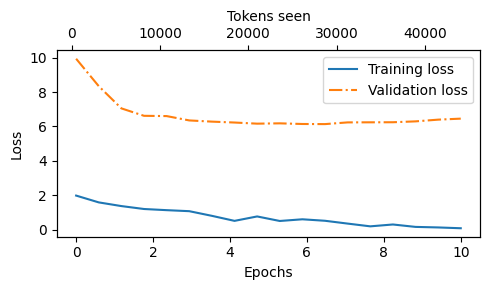

In [68]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)